In [2]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/processed')
sys.path.append(ROOT_DIR)  # To find local version of the library
# LABELS_DIR = os.path.join(ROOT_DIR, 'data/interim')


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# import cv2
# from IPython.display import display
import skimage
from skimage.draw import polygon
import json 

tf.compat.v1.disable_eager_execution()


In [3]:
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model
# from models.maskrcnn.mrcnn import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import model as modellib, utils

from src.data import helper

In [4]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class CustomConfig(Config):
  NAME = 'sidewalks'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + 1 sidewalk class 
  NUM_CLASSES = 1 + 10

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 10

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'

  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 256
  IMAGE_RESIZE_MODE = 'none'

  
class CustomDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,subset):
    # self.image_info = {}
    # self.class_info = {}
    # self.data_directory = dataset_dir

    classes = pd.read_csv(os.path.join(dataset_dir,'classes.csv'))
    classes = classes.set_index('CLASS_ID').T.to_dict('list')
    classes = dict([(k,classes[k][0]) for k,v in classes.items()])

    labels = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'), index_col=None)
    labels = labels.set_index('ID').T.to_dict('list')
    for id in labels:
      labs = labels[id][0]
      labels[id] =  np.array([int(i) for i in labs.split(' ')[:-1]])
    

    for class_id,class_name in classes.items():
      self.add_class(source='cityscape',
                   class_id = class_id,
                   class_name = class_name)
      
    # self.class_names = [d['name'] for d in self.class_info.values()]
    
    # iterating to get the image ids
    if subset == 'validation':
      subset = 'val'

    SUBSET_IDs = pd.read_csv(os.path.join(dataset_dir, subset+'.csv'), index_col=0) 
    SUBSET_IDs = [i.split('.')[0] for i in SUBSET_IDs['0'].tolist()]

    for ID in SUBSET_IDs:
    # for i in range(len(data)):
      img_path = os.path.join(dataset_dir, f'images/{ID}.png')
      img_labels = labels[ID]
      self.add_image(source='cityscape',
                     image_id = ID,
                     path = img_path,
                     labels = img_labels)
      
  def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # image_id = list(self.image_info.keys())[image_id]
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        image = skimage.transform.resize(image, (256,512))

        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
      
  def load_mask(self,id):
    # if not isinstance(id, str):
    #   id = self.image_info[id]

    img_info = self.image_info[id]
    img_name = img_info['id']
    mask_path = os.path.join(os.path.dirname(os.path.dirname(img_info['path']))
                        ,'segmentations',f'{img_name}.json')

    masks = helper.create_mask(mask_path, img_info['labels'], resize=(256,512))
    # masks = helper.create_mask(mask_path, img_info['labels'])

    return masks, img_info['labels']
  
  def image_reference(self, id):
    info = self.image_info[id]
    if info["source"] == "cityscape":
        return info["id"]
    else:
        super(self.__class__, self).image_reference(id)


In [6]:
config = CustomConfig()
config.display()

dataset = CustomDataset()
dataset.load_dataset(DATA_DIR,'train')
dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATA_DIR,'val')
val_set.prepare()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

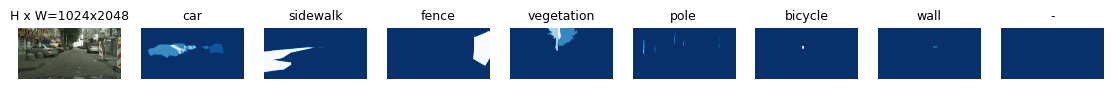

In [8]:
id = 0
img = dataset.load_image(id)
masks,labels = dataset.load_mask(id)
names = dataset.class_from_source_map

visualize.display_top_masks(img,
                            masks,
                            labels,
                            names,
                            limit=8)

In [ ]:
tf.keras.backend.clear_session()
temp_log = os.path.join(ROOT_DIR,'data/external')
model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset, val_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

# Inference

In [ ]:
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')

class InferenceConfig(CustomConfig):
  GPU_COUNT =1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = .5

inference_config = InferenceConfig()
temp_log = os.path.join(ROOT_DIR,'data/external')

tf.keras.backend.clear_session()
model = modellib.MaskRCNN(mode = 'inference',
                          config = inference_config,
                          model_dir=temp_log)
model.load_weights(model_path, by_name=True, 
                   exclude=['mrcnn_class_logits','mrcnn_bbox_fc','mrcnn_bbox','mrcnn_mask'])

Processing 1 images
image                    shape: (1024, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


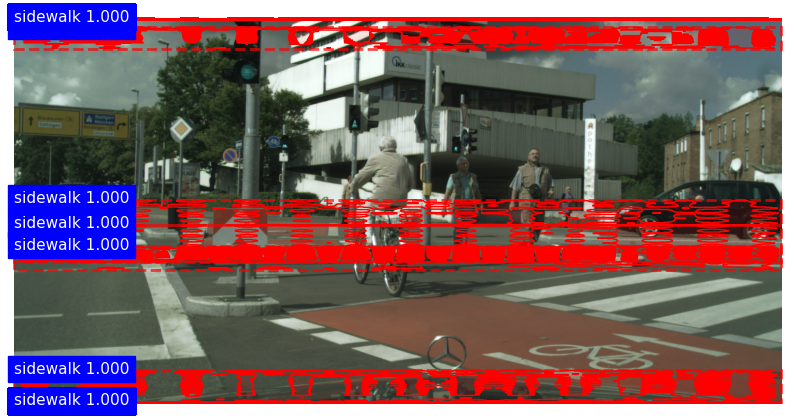

In [19]:
image= val_set.load_image(0)
results = model.detect([image],verbose=1)

# display preferences
def get_ax(rows=1, cols=1, size=10):
  _,ax = plt.subplots(rows,cols,figsize=(size*cols,size*rows))
  return ax

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            val_set.class_from_source_map, r['scores'], ax=get_ax(), )